In [43]:
%matplotlib inline
import numpy as np
import pyneb as pn
from matplotlib import pyplot as plt
import seaborn as sns
import polars as pl

## Set up oxygen ion spectra with PyNeb

Recombination of O++ gives the O II spectrum. 

In [2]:
oiir = pn.RecAtom("O", 2)

Collisional excitation of O++ gives the [O III] spectrum

In [3]:
oiiic = pn.Atom("O", 3)

In [4]:
oiiic.getTransition(5007)

(np.int64(4), np.int64(3))

In [5]:
pn.atomicData.getDataFile('O2', 'rec')

'o_ii_rec_SSB17-B-opt.hdf5'

O II recombination line data is from Storey+ [2017MNRAS.470..379S](https://ui.adsabs.harvard.edu/abs/2017MNRAS.470..379S/abstract)

In [6]:
pn.atomicData.getAllAtoms(coll=False, rec=True)

['H1',
 'He1',
 'He2',
 'C1',
 'C2',
 'C3',
 'C4',
 'N1',
 'N2',
 'N3',
 'N4',
 'Ne2',
 'O1',
 'O2',
 'O3',
 'O4',
 'O5',
 'N5',
 'O6']

In [7]:
[_ for _ in oiir.labels if _.startswith("43")]

['4312.11',
 '4313.44',
 '4315.35',
 '4315.83',
 '4322.45',
 '4342.00',
 '4303.61',
 '4315.38',
 '4309.00',
 '4324.79',
 '4315.69',
 '4315.39',
 '4309.01',
 '4371.24',
 '4340.32',
 '4331.16',
 '4371.61',
 '4332.69',
 '4374.32',
 '4343.36',
 '4335.36',
 '4334.18',
 '4343.50',
 '4334.32',
 '4334.03',
 '4327.58',
 '4307.23',
 '4384.70',
 '4353.59',
 '4345.55',
 '4344.37',
 '4354.21',
 '4346.17',
 '4344.99',
 '4305.39',
 '4397.82',
 '4366.53',
 '4358.44',
 '4357.25',
 '4303.82',
 '4366.80',
 '4358.71',
 '4357.22',
 '4317.70',
 '4304.08',
 '4395.93',
 '4369.27',
 '4347.41',
 '4347.22',
 '4351.26',
 '4349.43',
 '4319.63',
 '4366.89',
 '4336.86',
 '4317.14',
 '4345.56',
 '4325.76']

In [8]:
oiir.getTransition('4649.13')

In [9]:
oiir.getEmissivity(tem=np.linspace(5000, 10000, 6), den=1e4, label='4650.84')

array([2.55475947e-25, 2.20488455e-25, 1.94683724e-25, 1.74965871e-25,
       1.58873720e-25, 1.46000000e-25])

In [10]:
temperatures = np.geomspace(3000.0, 100_000.0, 200)

In [11]:
V1_mult = ('4638.86', '4641.81', '4649.13', '4650.84', '4661.63', '4673.73', '4676.23', '4696.35')
def oii_multiplet_sum_emissivity(tem, den, multiplet=V1_mult):
    result = None
    for label in multiplet:
        em = oiir.getEmissivity(tem=tem, den=den, label=label)
        if result is None:
            result = em
        else:
            result += em
    return result


def normalize(tem, em, T0=10_000.0):
    # Normalize to T = T0
    em0 = np.interp(T0, tem, em)
    return em / em0

In [12]:
V15_mult = "4590.97", #"4596.18", "4595.96"
V3d_4f = "4303.82", "4609.44", "4087.15", "4089.29"

In [13]:
oii_multiplet_sum_emissivity([1000, 3000, 5000, 8000, 1e4], 1e4, multiplet=V15_mult)

array([1.12900000e-25, 2.22026735e-25, 1.95540308e-25, 1.57714028e-25,
       1.38500000e-25])

In [14]:
sns.set_context("talk")
sns.set_color_codes("deep")

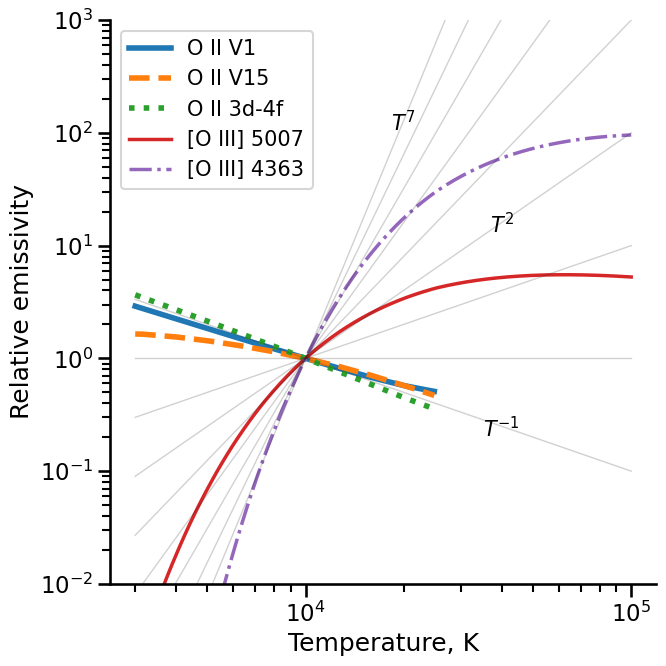

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
density = 1e2
T0 = 10_000.0

em = oii_multiplet_sum_emissivity(temperatures, density)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II V1", ls="-", lw=4)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V15_mult)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II V15", ls="--", lw=4)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V3d_4f)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II 3d-4f", ls=":", lw=4)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=5007)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[O III] 5007", ls="-", lw=2.5)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=4363)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[O III] 4363", ls="-.", lw=2.5)

for slope in [-1, 0, 1, 2, 3, 4, 5, 6, 7]:
    ax.plot(temperatures, (temperatures / T0)**slope, label=None, lw=1, alpha=0.2, color="k")

annotate_kws = dict(fontsize="small", horizontalalignment="center", verticalalignment="center_baseline")
ax.annotate("$T^{-1}$", (4e4, (4e4/T0)**-1), **annotate_kws)
ax.annotate("$T^{2}$", (4e4, (4e4/T0)**2), **annotate_kws)
ax.annotate("$T^{7}$", (2e4, (2e4/T0)**7), **annotate_kws)
ax.legend(fontsize="small")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[1e-2, 1e3],
    xlim=[None, None],
    xlabel="Temperature, K",
    ylabel="Relative emissivity",
)
sns.despine()
fig.tight_layout()
fig.savefig("oplusplus-emissivity-vs-t-loglog.pdf")

## Compare with formulae in Peimbert & Peimbert (2013)

These are equations (1, 2, 3)

In [18]:
def em_V1_PP13(T, T0=1e4):
    return (T / T0) ** (-0.755)

def em_4959_PP13(T, T0=1e4):
    result = T ** (-0.34) * np.exp(-29160 / T)
    result /= T0 ** (-0.34) * np.exp(-29160 / T0)
    return result

def em_4363_PP13(T, T0=1e4):
    result = T ** (-0.34) * np.exp(-62120 / T)
    result /= T0 ** (-0.34) * np.exp(-62120 / T0)
    return result
   

Repeat the previous graph but adding the PP13 curves

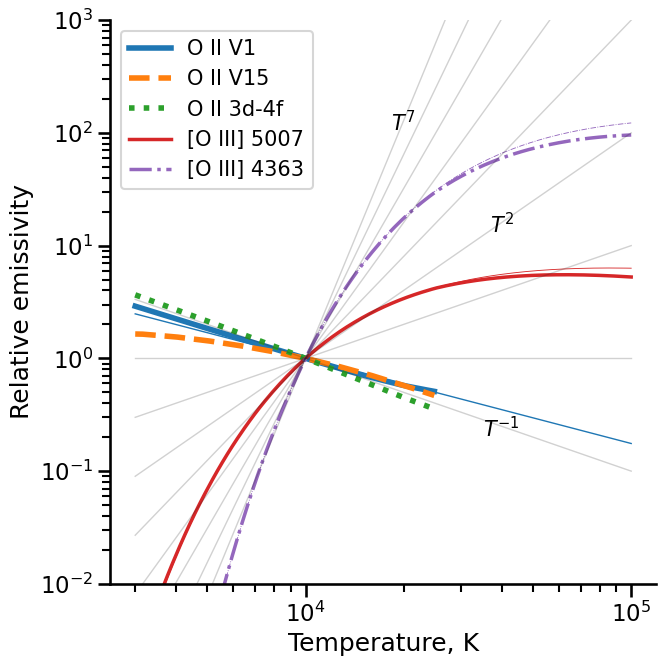

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
density = 1e2
T0 = 10_000.0

em = oii_multiplet_sum_emissivity(temperatures, density)
em = normalize(temperatures, em)
line, = ax.plot(temperatures, em, label="O II V1", ls="-", lw=4)
ax.plot(temperatures, em_V1_PP13(temperatures), label=None,
        color=line.get_color(), ls=line.get_ls(), 
        lw=line.get_lw()/4, alpha=1)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V15_mult)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II V15", ls="--", lw=4)

em = oii_multiplet_sum_emissivity(temperatures, density, multiplet=V3d_4f)
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="O II 3d-4f", ls=":", lw=4)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=5007)
em = normalize(temperatures, em)
line, = ax.plot(temperatures, em, label="[O III] 5007", ls="-", lw=2.5)
ax.plot(temperatures, em_4959_PP13(temperatures), label=None,
        color=line.get_color(), ls=line.get_ls(), 
        lw=line.get_lw()/4, alpha=1)

em = oiiic.getEmissivity(tem=temperatures, den=density, wave=4363)
em = normalize(temperatures, em)
line, = ax.plot(temperatures, em, label="[O III] 4363", ls="-.", lw=2.5)
ax.plot(temperatures, em_4363_PP13(temperatures), label=None,
        color=line.get_color(), ls=line.get_ls(), 
        lw=line.get_lw()/4, alpha=1)

for slope in [-1, 0, 1, 2, 3, 4, 5, 6, 7]:
    ax.plot(temperatures, (temperatures / T0)**slope, label=None, lw=1, alpha=0.2, color="k")

annotate_kws = dict(fontsize="small", horizontalalignment="center", verticalalignment="center_baseline")
ax.annotate("$T^{-1}$", (4e4, (4e4/T0)**-1), **annotate_kws)
ax.annotate("$T^{2}$", (4e4, (4e4/T0)**2), **annotate_kws)
ax.annotate("$T^{7}$", (2e4, (2e4/T0)**7), **annotate_kws)
ax.legend(fontsize="small")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[1e-2, 1e3],
    xlim=[None, None],
    xlabel="Temperature, K",
    ylabel="Relative emissivity",
)
sns.despine()
fig.tight_layout()
fig.savefig("oplusplus-emissivity-vs-t-loglog-with-PP13.pdf")

The agreement in the V1 emissivity is good for $T$ higher than 10,000 K so we can use the power law to extend the range beyond 30,000 K

The agreement in collisional emissivities is good up to 30,000 K, which is more than the stated range of validity in PP13 (5000 to 15,000 K). 

So, we can use PyNeb everywhere, except for V1 above 20,000 K, where we can use the power law. 

Note that this is for density 100 pcc. The V1 emissivities from PyNeb do vary with density, and at higher densities they deviate from the power law at the high T end of the range. 

## Calculating the logarithmic derivatives of the emissivities

In [77]:
density = 1e2
em4363 = oiiic.getEmissivity(tem=temperatures, den=density, wave=4363)
em5007 = oiiic.getEmissivity(tem=temperatures, den=density, wave=5007)
emV1 = oii_multiplet_sum_emissivity(temperatures, density)
emV1p = em_V1_PP13(temperatures)

In [78]:
q4363 = np.gradient(np.log(em4363), np.log(temperatures))
q5007 = np.gradient(np.log(em5007), np.log(temperatures))
qV1 = np.gradient(np.log(emV1), np.log(temperatures))
qV1p = np.gradient(np.log(emV1p), np.log(temperatures))

Make a polars dataframe just for fun

In [79]:
df = pl.DataFrame(
    {
        "T": temperatures,
        "qA": q4363,
        "qB": q5007,
        # "qC": np.where(np.isfinite(qV1), qV1, None),
        "qC": qV1,
        "qC PP13": qV1p,
    }
)

Look at every 20th row to get an overview

In [80]:
df[::20]

T,qA,qB,qC,qC PP13
f64,f64,f64,f64,f64
3000.0,19.990309,9.076648,-0.894427,-0.755
4267.508501,14.114758,6.379014,-0.89512,-0.755
6070.542936,9.842709,4.406491,-0.877131,-0.755
8635.364529,6.85759,3.039787,-0.875749,-0.755
12283.830514,4.717176,2.043251,-0.842796,-0.755
17473.783716,3.184693,1.317258,-0.731487,-0.755
24856.506852,2.077267,0.785915,NaN,-0.755
35358.451435,1.255868,0.364686,NaN,-0.755
50297.497365,0.734341,0.11656,NaN,-0.755


Correlations between columns

In [81]:
df.corr()

T,qA,qB,qC,qC PP13
f64,f64,f64,f64,f64
1.0,-0.709903,-0.716628,NaN,0.022358
-0.709903,1.0,0.999928,NaN,0.016608
-0.716628,0.999928,1.0,NaN,0.016191
NaN,NaN,NaN,NaN,NaN
0.022358,0.016608,0.016191,NaN,1.0


Note that polars makes a distinction between missing values (None) and float NaNs. However, when I tried that, it did not work with .corr()

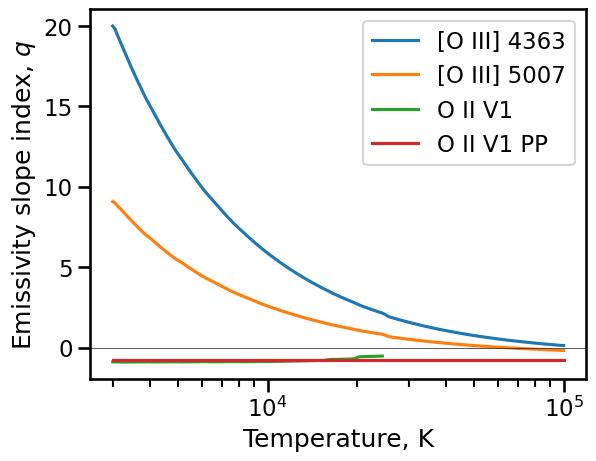

In [84]:
fig, ax = plt.subplots()
ax.plot("T", "qA", label="[O III] 4363", data=df)
ax.plot("T", "qB", label="[O III] 5007", data=df)
ax.plot("T", "qC", label="O II V1", data=df)
ax.plot("T", "qC PP13", label="O II V1 PP", data=df)
ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Emissivity slope index, $q$",
)
...;

## Calculating the bias factors, Q

In [90]:
def bias(qj, qk):
    Q = qj * (qj - 1) - qk * (qk - 1)
    Q /= 2 * (qj - qk)
    return Q

This seems to be the recommended way of making a new dataframe based on columns from the old one. First I use select() to take the T column from the original and add 3 bias columns. Then I use with_columns() to add two more columns for the differences. Maybe there is a way of doing it all at once, but I do not know how to allow the reference to new columns I have just created. 

In [99]:
bdf = df.select(
    pl.col("T"),
    bias(pl.col("qA"), pl.col("qB")).alias("Q_AB"),
    bias(pl.col("qB"), pl.col("qC")).alias("Q_BC"),
    bias(pl.col("qB"), pl.col("qC PP13")).alias("Q_BC PP13"),
).with_columns(
    dQ = (pl.col("Q_AB") - pl.col("Q_BC")),
    dQp = (pl.col("Q_AB") - pl.col("Q_BC PP13")),
)
bdf[::20]

T,Q_AB,Q_BC,Q_BC PP13,dQ,dQp
f64,f64,f64,f64,f64,f64
3000.0,14.033479,3.59111,3.660824,10.442368,10.372655
4267.508501,9.746886,2.241947,2.312007,7.504939,7.434879
6070.542936,6.6246,1.26468,1.325745,5.35992,5.298854
8635.364529,4.448689,0.582019,0.642394,3.866669,3.806295
12283.830514,2.880213,0.100227,0.144125,2.779986,2.736088
17473.783716,1.750976,-0.207114,-0.218871,1.95809,1.969847
24856.506852,0.931591,NaN,-0.484542,NaN,1.416134
35358.451435,0.310277,NaN,-0.695157,NaN,1.005434
50297.497365,-0.074549,NaN,-0.81922,NaN,0.744671


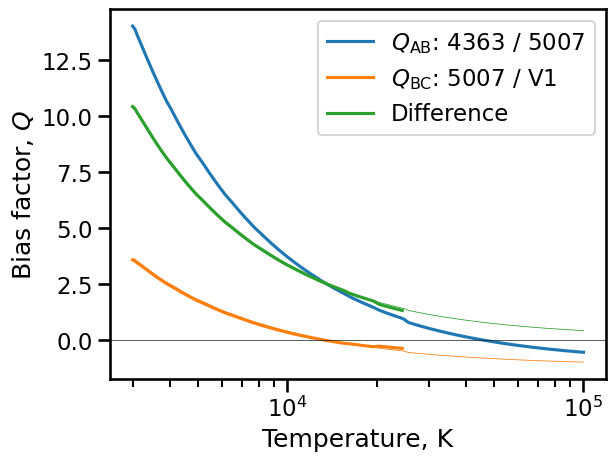

In [105]:
fig, ax = plt.subplots()
ax.plot("T", "Q_AB", label=r"$Q_\mathrm{AB}$: 4363 / 5007", data=bdf)
line, = ax.plot("T", "Q_BC", label=r"$Q_\mathrm{BC}$: 5007 / V1", data=bdf)
ax.plot("T", "Q_BC PP13", label="", data=bdf,
       color=line.get_color(), lw=line.get_lw() / 4)

line, = ax.plot("T", "dQ", label="Difference", data=bdf)
ax.plot("T", "dQp", label="", data=bdf,
       color=line.get_color(), lw=line.get_lw() / 4)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

## Fit a function to the Qs

### Polynomial fit in log10 T

This is the simplest option since it can be done in numpy

In [127]:
pfitAB = np.polynomial.Polynomial.fit(
    np.log10(bdf["T"]),
    bdf["Q_AB"],
    deg=4,
)
pfitAB

Polynomial([ 1.76490414, -4.71359266,  3.81200738, -2.55411311,  1.23236809], domain=[3.47712125, 5.        ], window=[-1.,  1.], symbol='x')

In [128]:
print(repr(pfitAB))

Polynomial([ 1.76490414, -4.71359266,  3.81200738, -2.55411311,  1.23236809], domain=[3.47712125, 5.        ], window=[-1.,  1.], symbol='x')


In [129]:
pfitAB.convert()

Polynomial([ 1769.9059267 , -1490.38028317,   475.31316113,   -67.9406171 ,
           3.66605628], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [134]:
pfitAB([3.5, 4.0, 4.5, 5.0])

array([13.34477107,  3.70628418,  0.50963354, -0.45842614])

In [139]:
bdf = bdf.with_columns(
    Q_AB_fit = pfitAB(np.log10(pl.col("T"))),
).with_columns(
    Q_AB_residual = 10 * (pl.col("Q_AB") - pl.col("Q_AB_fit")),
)

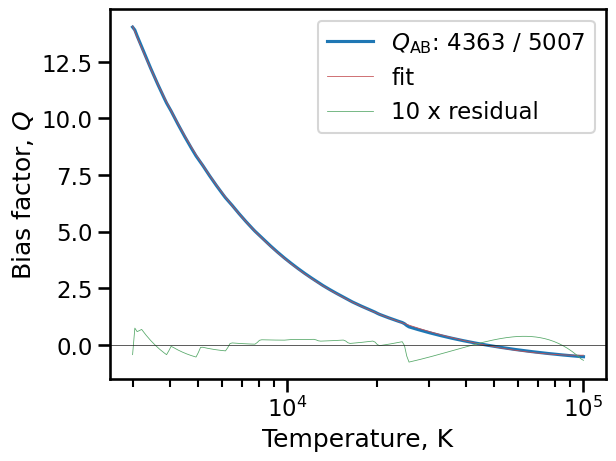

In [142]:
fig, ax = plt.subplots()
line, = ax.plot("T", "Q_AB", label=r"$Q_\mathrm{AB}$: 4363 / 5007", data=bdf)
ax.plot("T", "Q_AB_fit", label="fit", data=bdf,
       color="r", lw=line.get_lw() / 4)
ax.plot("T", "Q_AB_residual", label="10 x residual", data=bdf,
       color="g", lw=line.get_lw() / 4)

# line, = ax.plot("T", "Q_BC", label=r"$Q_\mathrm{BC}$: 5007 / V1", data=bdf)
# ax.plot("T", "Q_BC PP13", label="", data=bdf,
#        color=line.get_color(), lw=line.get_lw() / 4)

# line, = ax.plot("T", "dQ", label="Difference", data=bdf)
# ax.plot("T", "dQp", label="", data=bdf,
#        color=line.get_color(), lw=line.get_lw() / 4)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

So the 4th order polynomial gives a reasonable fit, except it will be very badly behaved outside the fitted range.

### Fit a constant plus 1/T^n

This may be better behaved. We will use astropy's modeling functionality

In [144]:
from astropy.modeling import models, fitting

We fix the x_0 normalization to be 1e4 K since there is no need to vary both that and the amplitude. We also try out fixing the power law index to be -1, just for simplicity. 

In [253]:
model = (
    models.PowerLaw1D(x_0=1e4, alpha=0.95, fixed={"x_0": True, "alpha": True}) 
    + models.Const1D(amplitude=-1.1, fixed={"amplitude": True})
)
fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
x, y = bdf["T"].to_numpy(), bdf["Q_AB"].to_numpy()
fitted_model = fitter(model, x, y)

Note that the LMLSQFitter did not work, strangely, but this Trust Region Reflective algorithm works fine

In [254]:
fitted_model

<CompoundModel(amplitude_0=4.83167161, x_0_0=10000., alpha_0=0.95, amplitude_1=-1.1)>

In [255]:
fitter.fit_info

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 3.117e-02 -8.912e-02 ... -2.579e-02 -3.077e-02]
           x: [ 4.832e+00]
        cost: 0.08752517984233255
         jac: [[ 3.139e+00]
               [ 3.086e+00]
               ...
               [ 1.141e-01]
               [ 1.122e-01]]
        grad: [ 8.110e-12]
  optimality: 8.110012661433075e-12
 active_mask: [ 0.000e+00]
        nfev: 4
        njev: 4
   param_cov: [[ 2.944e-06]]

Amazingly, it converged with only 4 function evaluations! 

In [256]:
np.sqrt(np.diagonal(fitter.fit_info.param_cov))

array([0.00171575])

The param_cov can be used to estimate the uncertainties in the parameters, which are very low. 

More important to look at the residuals:

In [257]:
residuals = y - fitted_model(x)
pl.Series(residuals).describe()

statistic,value
str,f64
"""count""",200.0
"""null_count""",0.0
"""mean""",-0.007159
"""std""",0.028777
"""min""",-0.076129
"""25%""",-0.022782
"""50%""",-0.003325
"""75%""",0.008083
"""max""",0.09022


So the rms residual is 0.07, which is not bad. If I allow the power law index to vary, then this is reduced to about 0.02. Taking the compromise power law index of -0.95, we still keep the rms at 0.03.

Now, we add the model and residual to the dataframe and look at the graph:

In [258]:
bdf = bdf.with_columns(
    Q_AB_fit = fitted_model(x),
    Q_AB_residual = 10 * residuals,
)

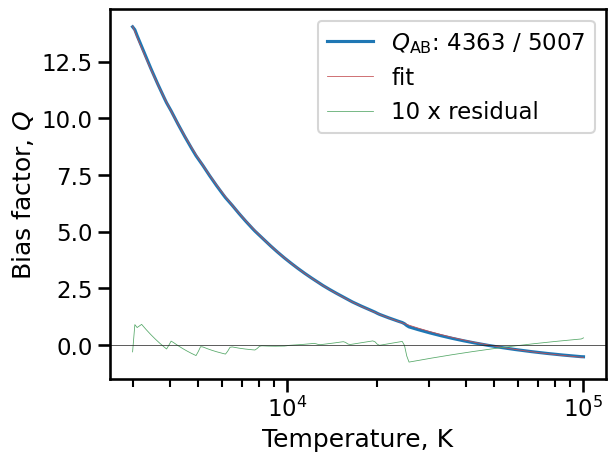

In [259]:
fig, ax = plt.subplots()
line, = ax.plot("T", "Q_AB", label=r"$Q_\mathrm{AB}$: 4363 / 5007", data=bdf)
ax.plot("T", "Q_AB_fit", label="fit", data=bdf,
       color="r", lw=line.get_lw() / 4)
ax.plot("T", "Q_AB_residual", label="10 x residual", data=bdf,
       color="g", lw=line.get_lw() / 4)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

So that looks really good. The residuals are about as good as for the 4th order polynomial fit, but with 2 parameters instead of 5!

The main problems are:
(1) the discontinuity at about 25000 K, which is a problem with PyNeb. 
(2) Inaccuracies at the lowest T, which is at least partially due to the edge effects with the numerical derivative calculation, but also suggests that power law index of -1 is not quite right. 

### Repeat for Q_BC

In [260]:
model = (
    models.PowerLaw1D(x_0=1e4, alpha=0.95, fixed={"x_0": True, "alpha": True}) 
    + models.Const1D(amplitude=-1.1, fixed={"amplitude": True})
)
fitter = fitting.TRFLSQFitter(calc_uncertainties=True)
x, y = bdf["T"].to_numpy(), bdf["Q_BC PP13"].to_numpy()
fitted_model = fitter(model, x, y)

In [261]:
fitted_model

<CompoundModel(amplitude_0=1.51534433, x_0_0=10000., alpha_0=0.95, amplitude_1=-1.1)>

In [262]:
fitter.fit_info

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-4.777e-03 -4.178e-02 ...  3.924e-02  3.776e-02]
           x: [ 1.515e+00]
        cost: 0.09806169729618089
         jac: [[ 3.139e+00]
               [ 3.086e+00]
               ...
               [ 1.141e-01]
               [ 1.122e-01]]
        grad: [ 8.707e-12]
  optimality: 8.706570187033691e-12
 active_mask: [ 0.000e+00]
        nfev: 2
        njev: 2
   param_cov: [[ 3.298e-06]]

In [263]:
np.sqrt(np.diagonal(fitter.fit_info.param_cov))

array([0.00181609])

In [264]:
residuals = y - fitted_model(x)
pl.Series(residuals).describe()

statistic,value
str,f64
"""count""",200.0
"""null_count""",0.0
"""mean""",-0.018826
"""std""",0.025087
"""min""",-0.05887
"""25%""",-0.043456
"""50%""",-0.010375
"""75%""",-0.002099
"""max""",0.046692


So the rms residuals are 0.03 with fixed index, or 0.01 with varying index. Or 0.02 with index and offset fixed at the values from the Q_AB fit. 

In [265]:
bdf = bdf.with_columns(
    Q_BC_fit = fitted_model(x),
    Q_BC_residual = 10 * residuals,
)

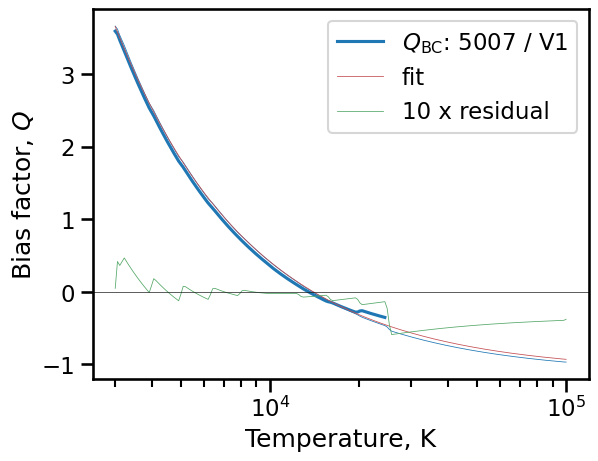

In [266]:
fig, ax = plt.subplots()
line, = ax.plot("T", "Q_BC", label=r"$Q_\mathrm{BC}$: 5007 / V1", data=bdf)
ax.plot("T", "Q_BC PP13", label="", data=bdf, color=line.get_color(), lw=line.get_lw() / 4)
ax.plot("T", "Q_BC_fit", label="fit", data=bdf, color="r", lw=line.get_lw() / 4)
ax.plot("T", "Q_BC_residual", label="10 x residual", data=bdf,
       color="g", lw=line.get_lw() / 4)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

## Summary of functional fits to the Q bias factors

The 3-parameter fits are as follows:
$$
Q_\mathrm{AB} = 4.80\, T_4^{-0.96} - 1.09
$$
and
$$
Q_\mathrm{BC} = 1.57\, T_4^{-0.94} - 1.16
$$


The compromise fits are as follows:
$$
Q_\mathrm{AB} = 4.83\, T_4^{-0.95} - 1.10
$$
and
$$
Q_\mathrm{BC} = 1.52\, T_4^{-0.95} - 1.10
$$


The second pair are clearly better because they greatly simpify the bias difference:
$$
Q_\mathrm{AB} - Q_\mathrm{BC} = 3.23\, T_4^{-0.95}
$$

The residuals of these fits are of order 0.03 or less, which is better than the accuracy of the Taylor expansion in the t2 analysis, which has relative truncation error of order $Q t^2 \approx 0.1$. 

### Comparison with Peimbert & Peimbert's bias factors

Equations (10, 11) of PP2013 give the Q values as the term in parentheses divided by 2.

In [283]:
def Q_AB(T):
    return (4.83 * (T / 1e4) ** -0.95) - 1.10

def Q_BC(T):
    return (1.52 * (T / 1e4) ** -0.95) - 1.10

def Q_AB_PP(T):
    return 0.5 * ((91300 / T) - 2.68)

def Q_BC_PP(T):
    fac = 29160 / T
    return 0.5 * (fac - 3.095 + 0.415 / (fac + 0.415))



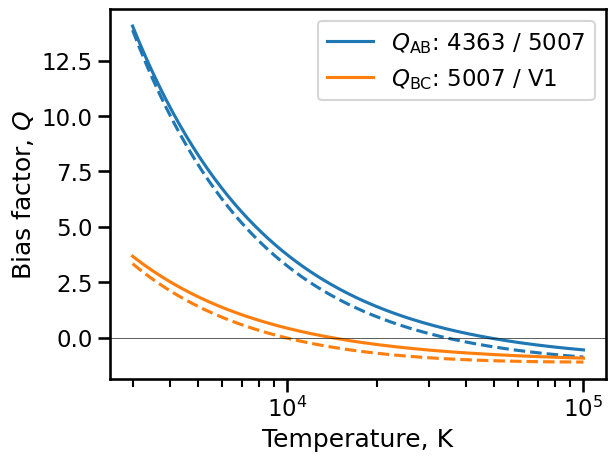

In [287]:
fig, ax = plt.subplots()
line, = ax.plot(
    temperatures, Q_AB(temperatures),
    label=r"$Q_\mathrm{AB}$: 4363 / 5007"
)
ax.plot(
    temperatures, Q_AB_PP(temperatures),
    label="", color=line.get_color(), lw=line.get_lw(), ls="dashed",
)

line, = ax.plot(
    temperatures, Q_BC(temperatures),
    label=r"$Q_\mathrm{BC}$: 5007 / V1"
)
ax.plot(
    temperatures, Q_BC_PP(temperatures),
    label="", color=line.get_color(), lw=line.get_lw(), ls="dashed",
)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

## Repeat everything for [N II]

Here we only have the collisional lines to deal with, since there are no  recombination N I lines. 

In [269]:
niic = pn.Atom("N", 2)
niic.getTransition(5755)

(np.int64(5), np.int64(4))

In [271]:
density = 100.0
em6583 = niic.getEmissivity(tem=temperatures, den=density, wave=6583)
em5755 = niic.getEmissivity(tem=temperatures, den=density, wave=5755)

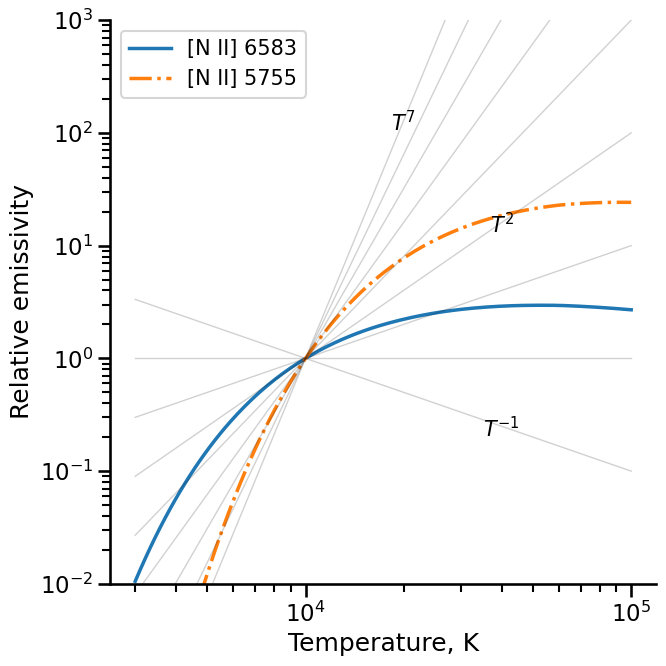

In [272]:
fig, ax = plt.subplots(figsize=(7, 7))
density = 1e2
T0 = 10_000.0

em = em6583
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[N II] 6583", ls="-", lw=2.5)

em = em5755
em = normalize(temperatures, em)
ax.plot(temperatures, em, label="[N II] 5755", ls="-.", lw=2.5)

for slope in [-1, 0, 1, 2, 3, 4, 5, 6, 7]:
    ax.plot(temperatures, (temperatures / T0)**slope, label=None, lw=1, alpha=0.2, color="k")

annotate_kws = dict(fontsize="small", horizontalalignment="center", verticalalignment="center_baseline")
ax.annotate("$T^{-1}$", (4e4, (4e4/T0)**-1), **annotate_kws)
ax.annotate("$T^{2}$", (4e4, (4e4/T0)**2), **annotate_kws)
ax.annotate("$T^{7}$", (2e4, (2e4/T0)**7), **annotate_kws)
ax.legend(fontsize="small")
ax.set(
    xscale="log",
    yscale="log",
    ylim=[1e-2, 1e3],
    xlim=[None, None],
    xlabel="Temperature, K",
    ylabel="Relative emissivity",
)
sns.despine()
fig.tight_layout()
fig.savefig("nplus-emissivity-vs-t-loglog.pdf")

In [273]:
q5755 = np.gradient(np.log(em5755), np.log(temperatures))
q6583 = np.gradient(np.log(em6583), np.log(temperatures))

In [274]:
ndf = pl.DataFrame(
    {
        "T": temperatures,
        "qA": q5755,
        "qB": q6583,
    }
)
ndf[::20]

T,qA,qB
f64,f64,f64
3000.0,15.032348,6.767278
4267.508501,10.547372,4.664218
6070.542936,7.294441,3.145278
8635.364529,4.996965,2.079734
12283.830514,3.386932,1.351418
17473.783716,2.250008,0.829684
24856.506852,1.458396,0.479765
35358.451435,0.89587,0.214207
50297.497365,0.4848,0.023393


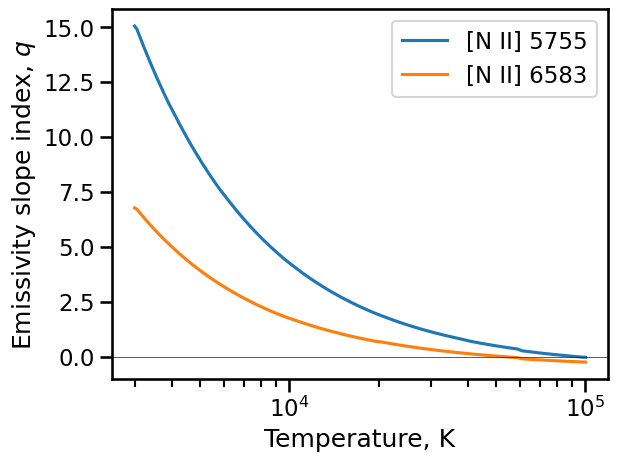

In [275]:
fig, ax = plt.subplots()
ax.plot("T", "qA", label="[N II] 5755", data=ndf)
ax.plot("T", "qB", label="[N II] 6583", data=ndf)
ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Emissivity slope index, $q$",
)
...;

In [276]:
nbdf = ndf.select(
    pl.col("T"),
    bias(pl.col("qA"), pl.col("qB")).alias("Q_AB"),
)
nbdf[::20]

T,Q_AB
f64,f64
3000.0,10.399813
4267.508501,7.105795
6070.542936,4.719859
8635.364529,3.03835
12283.830514,1.869175
17473.783716,1.039846
24856.506852,0.469081
35358.451435,0.055038
50297.497365,-0.245903


In [279]:
model = (
    models.PowerLaw1D(x_0=1e4, alpha=0.95, fixed={"x_0": True, "alpha": False}) 
    + models.Const1D(amplitude=-1.1, fixed={"amplitude": False})
)
x, y = nbdf["T"].to_numpy(), nbdf["Q_AB"].to_numpy()
fitted_model = fitter(model, x, y)
fitted_model

<CompoundModel(amplitude_0=3.47582732, x_0_0=10000., alpha_0=0.98881313, amplitude_1=-0.96531984)>

In [280]:
residuals = y - fitted_model(x)
pl.Series(residuals).describe()  

statistic,value
str,f64
"""count""",200.0
"""null_count""",0.0
"""mean""",2.7224e-9
"""std""",0.018519
"""min""",-0.065955
"""25%""",-0.012024
"""50%""",0.000711
"""75%""",0.015758
"""max""",0.032133


In [281]:
nbdf = nbdf.with_columns(
    Q_AB_fit = fitted_model(x),
    Q_AB_residual = 10 * residuals,
)

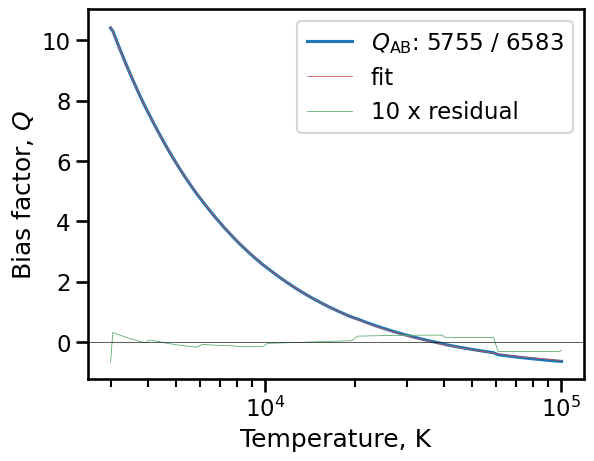

In [282]:
fig, ax = plt.subplots()
line, = ax.plot("T", "Q_AB", label=r"$Q_\mathrm{AB}$: 5755 / 6583", data=nbdf)
ax.plot("T", "Q_AB_fit", label="fit", data=nbdf,
       color="r", lw=line.get_lw() / 4)
ax.plot("T", "Q_AB_residual", label="10 x residual", data=nbdf,
       color="g", lw=line.get_lw() / 4)

ax.axhline(color="k", lw=0.5)
ax.legend()
ax.set(
    xscale="log",
    xlabel="Temperature, K",
    ylabel="Bias factor, $Q$",
)
...;

So rms residuals of 0.02 or so. 

In [215]:
fitter?

Signature:     
fitter(
    model,
    x,
    y,
    z=None,
    weights=None,
    maxiter=100,
    acc=1e-07,
    epsilon=np.float64(1.4901161193847656e-08),
    estimate_jacobian=False,
    filter_non_finite=False,
)
Type:           TRFLSQFitter
String form:    <astropy.modeling.fitting.TRFLSQFitter object at 0x12d2ab410>
File:           ~/Dropbox/turb-t2-paper/.venv/lib/python3.12/site-packages/astropy/modeling/fitting.py
Docstring:     
Trust Region Reflective algorithm and least squares statistic.

Parameters
----------
calc_uncertainties : bool
    If the covariance matrix should be computed and set in the fit_info.
    Default: False
use_min_max_bounds: bool
    If the set parameter bounds for a model will be enforced each given
    parameter while fitting via a simple min/max condition. A True setting
    will replicate how LevMarLSQFitter enforces bounds.
    Default: False

Attributes
----------
fit_info :
    A `scipy.optimize.OptimizeResult` class which contains all of
    

In [209]:
fitting.TRFLSQFitter?

Init signature: fitting.TRFLSQFitter(calc_uncertainties=False, use_min_max_bounds=False)
Docstring:     
Trust Region Reflective algorithm and least squares statistic.

Parameters
----------
calc_uncertainties : bool
    If the covariance matrix should be computed and set in the fit_info.
    Default: False
use_min_max_bounds: bool
    If the set parameter bounds for a model will be enforced each given
    parameter while fitting via a simple min/max condition. A True setting
    will replicate how LevMarLSQFitter enforces bounds.
    Default: False

Attributes
----------
fit_info :
    A `scipy.optimize.OptimizeResult` class which contains all of
    the most recent fit information
File:           ~/Dropbox/turb-t2-paper/.venv/lib/python3.12/site-packages/astropy/modeling/fitting.py
Type:           _FitterMeta
Subclasses:     

In [97]:
df.with_columns?

Signature:
df.with_columns(
    *exprs: 'IntoExpr | Iterable[IntoExpr]',
    **named_exprs: 'IntoExpr',
) -> 'DataFrame'
Docstring:
Add columns to this DataFrame.

Added columns will replace existing columns with the same name.

Parameters
----------
*exprs
    Column(s) to add, specified as positional arguments.
    Accepts expression input. Strings are parsed as column names, other
    non-expression inputs are parsed as literals.
**named_exprs
    Additional columns to add, specified as keyword arguments.
    The columns will be renamed to the keyword used.

Returns
-------
DataFrame
    A new DataFrame with the columns added.

Notes
-----
Creating a new DataFrame using this method does not create a new copy of
existing data.

Examples
--------
Pass an expression to add it as a new column.

>>> df = pl.DataFrame(
...     {
...         "a": [1, 2, 3, 4],
...         "b": [0.5, 4, 10, 13],
...         "c": [True, True, False, True],
...     }
... )
>>> df.with_columns((pl.col("a") ** 